## Programming Assignment 5
#### In this assignment, you will be implementing Tomasi-Kanade	Factorization algorithm	for Rigid Structure from Motion.

### Task 1
#### Load the data file and generate a 2D image dataset	by generating an orthographic camera with optical axis paralle to the XY plane, which rotates around the teapot	in 10° increments and always looks towards the center of the object
#### Note: Code for loading the point cloud and visualizing it has been given to you. Further build on it and take images of the teapot and visualize them

In [0]:
from scipy.io import loadmat
x = loadmat('teapot.mat')

In [0]:
a = []
b = []
c = []
for points in x['verts']:
    a.append(points[0])
    b.append(points[1])
    c.append(points[2])

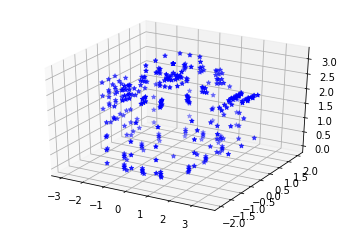

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,c, c='b', marker='*')

In [0]:
### Your implementation comes here
import numpy as np
import math
intrinsic = np.array([[1, 0, 0],[0, 1, 0]])

def rotation_matrix_y(angle):
    rot_angle=math.radians(angle)
    R = np.array([[math.cos(rot_angle),0,math.sin(rot_angle)],[0,1,0],[-math.sin(rot_angle),0,math.cos(rot_angle)]])
    return R      

frames: 36, points: 3
new2Dpts shape (36, 2, 306) R shape (36, 3, 3) old2Dpts shape (3, 306)
Frame 0


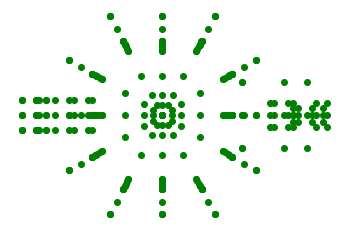

Frame 1


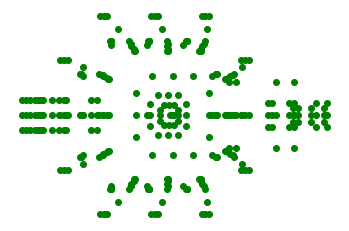

Frame 2


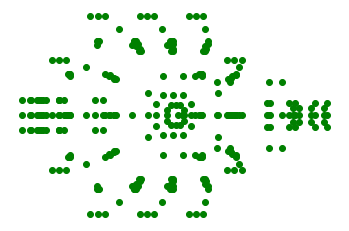

Frame 3


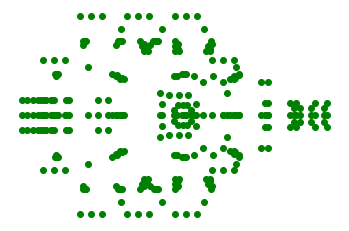

Frame 4


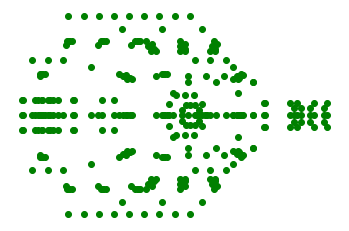

Frame 5


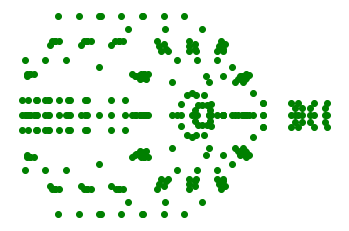

Frame 6


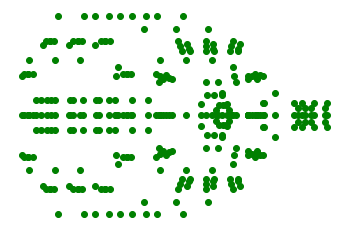

Frame 7


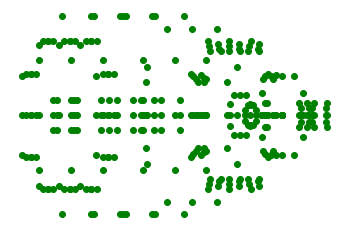

Frame 8


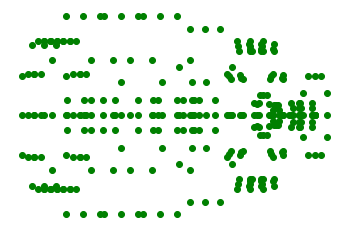

Frame 9


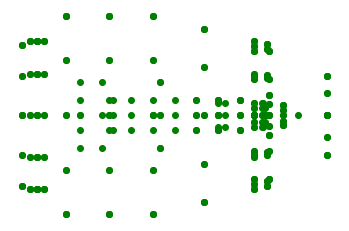

Frame 10


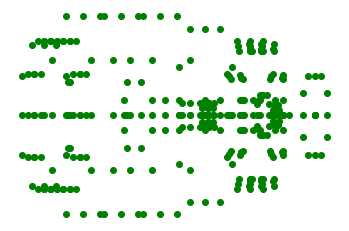

Frame 11


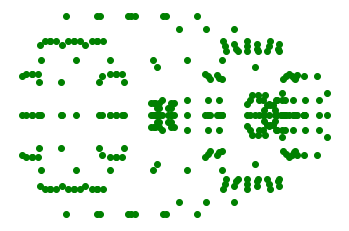

Frame 12


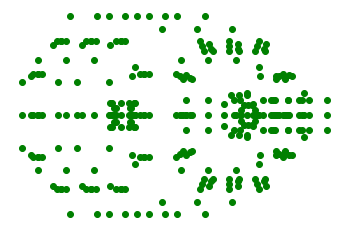

Frame 13


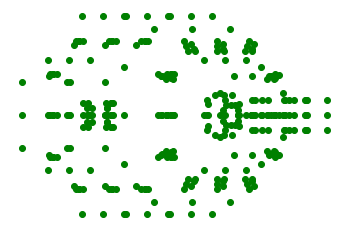

Frame 14


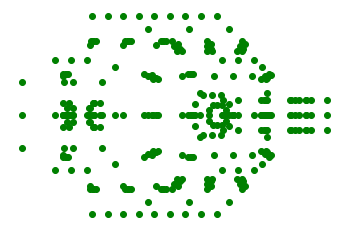

Frame 15


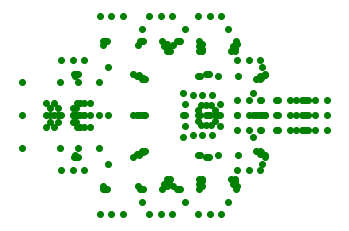

Frame 16


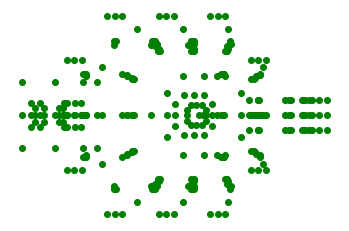

Frame 17


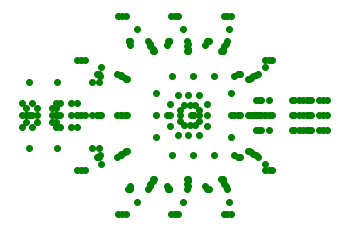

Frame 18


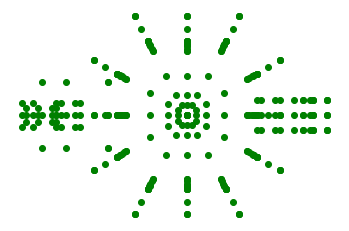

Frame 19


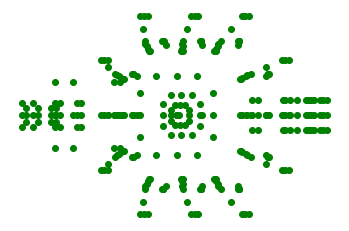

Frame 20


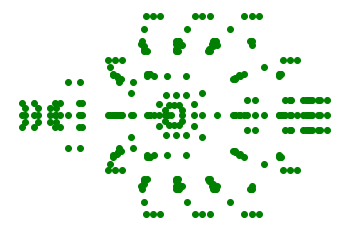

Frame 21


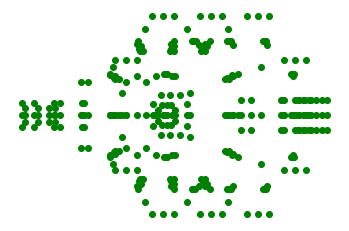

Frame 22


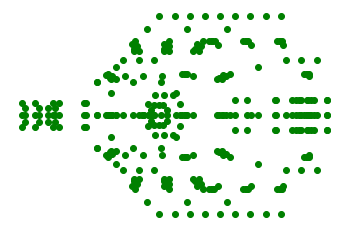

Frame 23


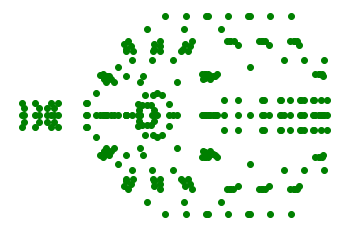

Frame 24


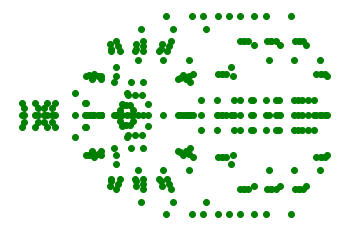

Frame 25


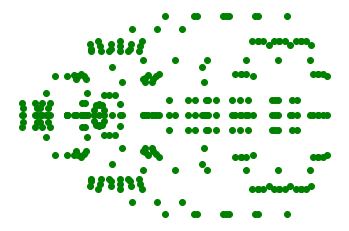

Frame 26


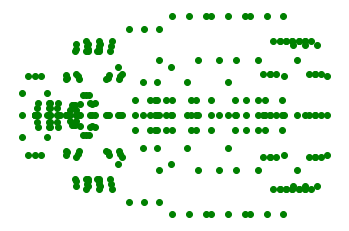

Frame 27


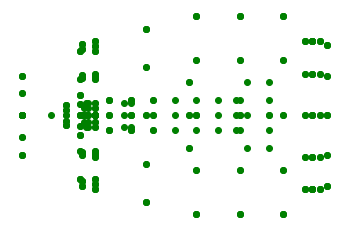

Frame 28


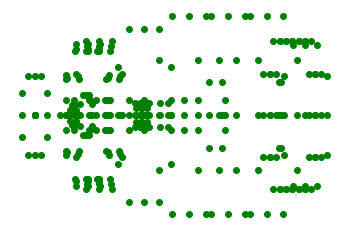

Frame 29


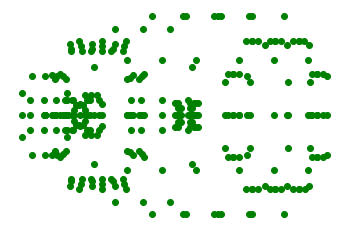

Frame 30


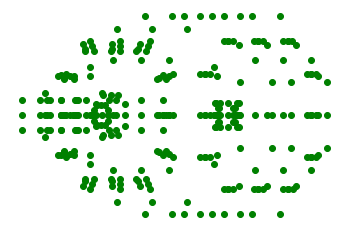

Frame 31


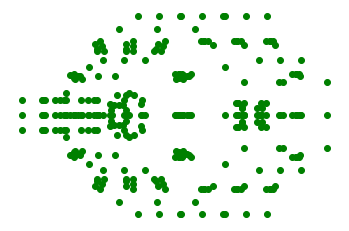

Frame 32


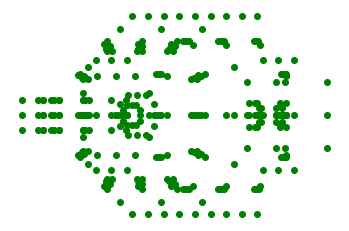

Frame 33


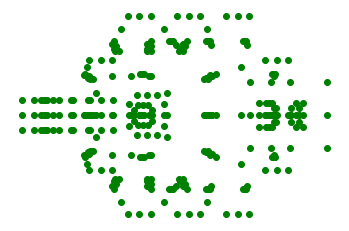

Frame 34


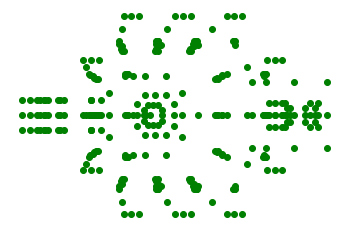

Frame 35


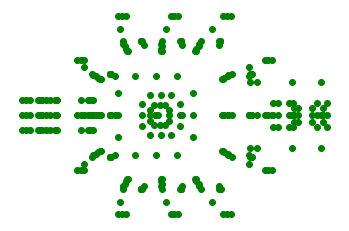

In [17]:
### Your implementation comes here
# Hint: new2Dpts = K[R|T]*3DPoints

old2Dpts = np.array(list(zip(a,b,c))).T

K = intrinsic
# T = [0, 0, 0] image offset, translation eliminated
#  rotates around the teapot in 10° increment
P = len(old2Dpts) # 306 points total

R = [] # calculating rotation matrices for every frame
for angle in range (0, 360, 10):
  # 3D rotation about y axis, so y remains the same
  R.append(rotation_matrix_y(angle)) # current R
R = np.array(R)
F = len(R)
print(f"frames: {F}, points: {P}")
new2Dpts = np.matmul(K, np.matmul(R, old2Dpts)) # for all time frames (specific angle)
# W(measurement) = R(motion) x S(shape) will be computed by tomasi kanade factorization
print(f"new2Dpts shape {new2Dpts.shape} R shape {R.shape} old2Dpts shape {old2Dpts.shape}")
#new2Dpts shape (36, 2, 306) R shape (36, 3, 3) old2Dpts shape (306, 3)

f = 0
for new2DptArr in new2Dpts:
  plt.axis('off')
  print(f"Frame {f}")
  plt.scatter(new2DptArr[0], new2DptArr[1], c='g')
  plt.show()
  f += 1

### Task 2
#### Use the data generated in previous task to generate a W matrix, and use that as input in Tomasi Kanade Factorization method to compute the 3D structure

In [0]:
### Your implementation for Tomasi Kanade Factorization method comes here

def factorize_tk(w): # factor measurement matrix w
  u, d, vh = np.linalg.svd(w) 
  # vh.T is v, u(2Fx2F) and v(PxP) are orthonormal, d is diagonal
  v = vh.T
  # w is a rank 3 matrix ideally
  # u' and vt' == first 3 columns of u and v, d' == principal 3x3 block of D
  # because 3 is ideal rank, but may exceed 3 due to noise, so we extract these only
  u_prime = u[:, :3] # from n x n to n x 3 
  vt_prime = v[:, :3].T
  d_prime = np.zeros((3,3), dtype='float32')
  for i in range(3):
    d_prime[i][i] = d[i]# d has diagonal values

  # motion matrix (REMINDER m == r)
  m = np.matmul(u_prime, np.sqrt(np.abs(d_prime))) # or r^
  # shape matrix
  s = np.sqrt(np.abs(np.matmul(d_prime, vt_prime)))


  # remove affine ambiguity with enforcement of euclidean constraints on the motion matrix m
  A = np.zeros((3*F, 6), dtype='float32') # invertible A such that M = M^ A and S = Ainv S^
  B = np.zeros((3*F, 1), dtype='float32')
  # Aq = B (q or x same thing)
  # q = q1, q2, q3, q4... solution

  i = 0
  for f in range(0, m.shape[0], 2): # going over every 2 rows (frame wise) in m^ or r^ (0, 1,... i, i+1)
    r1, r2, r3 = m[f] 
    r4, r5, r6 = m[f + 1]
    # calculated on paper first
    A[i] = np.array([r1*r1, 2*r1*r2, r1*r3, r1*r3 + r2*r2, 2*r2*r3, r3*r3])
    A[i + 1] = np.array([r1*r4, r2*r4 + r1*r5, r1*r6, r3*r4 + r2*r5, r3*r5 + r2*r6, r3*r6])
    A[i + 2] = np.array([r4*r4, 2*r5*r4, r4*r6, r4*r6 + r5*r5, 2*r5*r6, r6*r6])
    B[i], B[i + 1], B[i + 2] = 1, 0, 1
    i += 3 # calculating three rows at a time

  # A and B calculated in Aq = B 
  # q = q1, q2, q3, q4... solution, formula from lecture applied
  q1, q2, q3, q4, q5, q6 = np.matmul(np.matmul(np.linalg.inv(np.matmul(A.T, A)), A.T), B).reshape(-1) # converted to row vector
  
  # here QQT = QQ^T, 6 unknowns as QQT is 3 x 3 symmetric
  QQT = np.array([[q1, q2, q3], [q2, q4, q5], [q4, q5, q6]], dtype='float32')
 
  Q = np.linalg.cholesky(QQT)

  # shape matrix s with all the reconstructed points returned
  s = np.matmul(np.linalg.inv(Q), vt_prime)
   
  return s

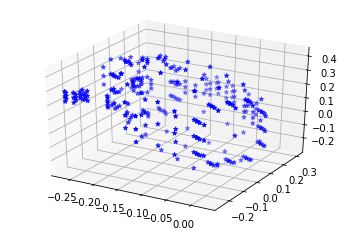

In [10]:
## Plot the reconstructed mode

# In the base code above we copied the x, y and z compr1nt of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z compr1nt of the reconstructed 3D points are 
# in variables a1, b1 and c1 respectively, the reconstructed model can be plotted as:
w = []
for new2DptArr in new2Dpts:
  w.append(new2DptArr[0])
  w.append(new2DptArr[1])
w = np.array(w)

# print(new2Dpts.shape, w.shape)
reconstructed_pts = factorize_tk(w)
a1, b1, c1 = reconstructed_pts

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a1,b1,c1, c='b', marker='*')
plt.show()

In [11]:
## Evaluate your reconstruction
# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the 3D points that you have reconstructed are 
# in variables a1, b1 and c1 respectively, the error in reconstruction can be calcualted as:

err = 0.0
j = 0
for i in range(len(a1)):
  err = err + math.sqrt( ((a1[i]-a[i])*(a1[i]-a[i])) + ((b1[i]-b[i])*(b1[i]-b[i])) + ((c1[i]-c[i])*(c1[i]-c[i])) )
  j=j+1
  
print ("Mean Euclidean Error : ",(err/j))

Mean Euclidean Error :  2.596725440765055
